In [ ]:
# *** นำเข้าไลบรารีที่จำเป็น ***
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.deterministic import Fourier

# ------------------------------------------------------------

# โหลดข้อมูลจากไฟล์ CSV 
df = pd.read_csv("dataset\export-jsps001-1h.csv")

# ------------------------------------------------------------

# *** ตรวจสอบข้อมูล และทำความสะอาดข้อมูล หลังจากโหลด ***

# แปลงคอลัมน์ 'timestamp' ให้เป็นรูปแบบ datetime และตั้งเป็น index
df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed") # แปลงให้เป็น datetime
df.set_index("timestamp", inplace=True) # ตั้งคอลัมน์ 'timestamp' เป็น index

# เลือกข้อมูลเฉพาะ 2 ปีที่ผ่านมา
one_year_ago = df.index.max() - pd.DateOffset(years=2) # หาวันที่ 2 ปีที่ผ่านมา
df = df[df.index >= one_year_ago]  # กรองข้อมูลเฉพาะ 2 ปีที่ผ่านมา

# ลบคอลัมน์ที่ไม่จำเป็นออก
df.drop(columns=["timezone", "Unnamed: 0", "pm_2_5_sp","location"], inplace=True, errors="ignore")

# ลบค่าผิดปกติ (Outliers) โดยใช้ IQR (Interquartile Range)
Q1 = df["pm_2_5"].quantile(0.25) # หา Q1
Q3 = df["pm_2_5"].quantile(0.75) # หา Q3

IQR = Q3 - Q1 # หา IQR
df = df[(df["pm_2_5"] >= Q1 - 1.5 * IQR) & (df["pm_2_5"] <= Q3 + 1.5 * IQR)] # กรองค่าที่อยู่ในช่วง Q1 - 1.5 * IQR ถึง Q3 + 1.5 * IQR

# ทำเช่นเดียวกันกับคอลัมน์ 'temperature' และ 'humidity'
Q1t = df["temperature"].quantile(0.25) # หา Q1
Q3t = df["temperature"].quantile(0.75) # หา Q3

IQRt = Q3t - Q1t # หา IQR
df = df[(df["temperature"] >= Q1t - 1.5 * IQRt) & (df["temperature"] <= Q3t + 1.5 * IQRt)] # กรองค่าที่อยู่ในช่วง Q1 - 1.5 * IQR ถึง Q3 + 1.5 * IQR

Q1h = df["humidity"].quantile(0.25) # หา Q1
Q3h = df["humidity"].quantile(0.75) # หา Q3

IQRh = Q3h - Q1h # หา IQR
df = df[(df["humidity"] >= Q1h - 1.5 * IQRh) & (df["humidity"] <= Q3h + 1.5 * IQRh)] # กรองค่าที่อยู่ในช่วง Q1 - 1.5 * IQR ถึง Q3 + 1.5 * IQR
print(df)

# ทำการเติมค่าที่หายไปโดยใช้วิธี Interpolation
df.interpolate(method="linear", inplace=True) 

# ทำการ Resample ข้อมูลเป็นรายวันและเติมค่าที่หายไปด้วยวิธี Forward Fill
df = df.resample("D").mean().fillna(method="ffill") 

# ทำการ Resample ข้อมูลเป็นรายวันอีกครั้ง
df = df.resample("D").mean()

# เพิ่ม Fourier Terms สำหรับ Weekly Seasonality
fourier = Fourier(period=7, order=2) # สร้าง Fourier Object โดยใช้ Period 7 และ Order 2
fourier_features = fourier.in_sample(df.index) # สร้าง Fourier Features จากข้อมูลที่มีอยู่
df = pd.concat([df, fourier_features], axis=1) # รวมข้อมูลเข้าด้วยกัน
df.dropna(inplace=True) # ลบค่าที่หายไป

# เพิ่ม Lag Features สำหรับ Short-Term และ Long-Term
for lag in [7 +1, 7 + 3, 7 + 7, 7 + 14]: # สร้าง Lag สำหรับ Short-Term
    df[f"pm_2_5_lag{lag}"] = df["pm_2_5"].shift(lag) # สร้าง Lag ของ pm_2_5 สำหรับ Short-Term
    df[f"humidity_lag{lag}"] = df["humidity"].shift(lag) # สร้าง Lag ของ humidity สำหรับ Short-Term
    df[f"temperature_lag{lag}"] = df["temperature"].shift(lag) # สร้าง Lag ของ temperature สำหรับ Short-Term

# เพิ่ม Rolling Mean และ Rolling Std สำหรับหลายระดับ
for window in [2, 3, 5,7,14]: 
    df[f"pm_2_5_rollmean{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).mean() # สร้าง Rolling Mean ของ pm_2_5
    )
    df[f"pm_2_5_rollstd{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).std() # สร้าง Rolling Std ของ pm_2_5
    )
    df[f"humidity_rollmean{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).mean() # สร้าง Rolling Mean ของ humidity
    )
    df[f"humidity_rollstd{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).std() # สร้าง Rolling Std ของ humidity
    )
    df[f"temperature_rollmean{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).mean() # สร้าง Rolling Mean ของ temperature
    )
    df[f"temperature_rollstd{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).std() # สร้าง Rolling Std ของ temperature
    )

# ลบคอลัมน์ 'temperature' และ 'humidity' หลังจากทำการเพิ่ม Feature แล้ว
df = df.drop(columns=["temperature","humidity"]) 
df = df.asfreq("D").fillna(method="bfill")  # ทำการเติมค่าที่หายไปด้วยวิธี Backward Fill


# แบ่งข้อมูลสำหรับฝึกและทดสอบ (7 วัน = 28 ช่วง) 
train = df.iloc[:-7]  # แบ่ง train
test = df.iloc[-7:]  # แบ่ง test

# เลือกเฉพาะฟีเจอร์ที่สำคัญ
selected_features = ["pm_2_5"] + [col for col in df.columns if col != "pm_2_5"] # เลือกเฉพาะคอลัมน์ที่ต้องการ
train = train[selected_features] # กรองคอลัมน์ที่ต้องการ สำหรับ Train
test = test[selected_features] # กรองคอลัมน์ที่ต้องการ สำหรับ Test

# ------------------------------------------------------------

                       humidity     pm_2_5  temperature
timestamp                                              
2023-02-11 12:00:00  100.000000  11.512397    33.274298
2023-02-11 13:00:00  100.000000  11.091667    33.866417
2023-02-11 14:00:00  100.000000   8.554622    34.371176
2023-02-11 15:00:00   97.793479   8.347107    34.806281
2023-02-11 16:00:00   98.446084  10.350000    34.604583
...                         ...        ...          ...
2025-02-11 08:00:00   87.340026  43.263158    23.013561
2025-02-11 09:00:00   80.816273  42.478992    25.590026
2025-02-11 10:00:00   67.041454  40.848214    29.023077
2025-02-11 11:00:00   53.353909  31.842105    32.314087
2025-02-11 11:12:18   52.840677  31.750000    32.533843

[16442 rows x 3 columns]


In [14]:
# *** การเตรียมข้อมูลสำหรับการทำ Time Series Forecasting ด้วย Pycaret ***

# ตั้งค่า Experiment สำหรับ Time Series Forecasting 
experiment = setup(
    data=train, # ใช้ข้อมูลสำหรับ Train
    target="pm_2_5", # ตั้งค่า Target เป็น pm_2_5
    session_id=123, # ตั้งค่า Random Seed เป็น 123
    use_gpu=True, # ใช้ GPU
    fh=7, # ทำการพยากรณ์ 7 วัน
    fold=5, # ใช้ 5 Folds
    seasonal_period="D", # ตั้งค่า Seasonal Period เป็น Daily
    verbose=True, # แสดง Log ของการทำงาน
)

test.index = test.index.to_period("D") # แปลง Index ของ Test เป็น Period

# สร้างโมเดล ARIMA และปรับแต่งโมเดล
arima_model = create_model("arima") # สร้างโมเดล ARIMA
arima_model = tune_model(arima_model) # ปรับแต่งโมเดล ARIMA
final_arima = finalize_model(arima_model) # ปรับแต่งโมเดล ARIMA อีกครั้ง

# ทำการพยากรณ์โดยใช้โมเดลที่ปรับแต่งแล้ว
X_forecast = test.drop(columns=["pm_2_5"]) # ตั้งค่า X_forecast โดยไม่รวมคอลัมน์ 'pm_2_5'
predictions = predict_model(final_arima, X=X_forecast) # *** ทำการพยากรณ์ ***

# ------------------------------------------------------------

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(725, 47)"
5,Transformed data shape,"(725, 47)"
6,Transformed train set shape,"(718, 47)"
7,Transformed test set shape,"(7, 47)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-24,1.1797,1.0724,9.8549,11.3571,0.6833,0.4619,0.2381
1,2024-12-31,1.4834,1.4419,12.4386,15.3247,0.3398,0.4543,-7.5737
2,2025-01-07,0.3828,0.4107,3.2282,4.3923,0.1008,0.1126,0.1034
3,2025-01-14,1.4543,1.3146,12.2104,14.0077,0.3411,0.3729,-0.9906
4,2025-01-21,0.7712,0.7147,6.4900,7.6213,0.2009,0.1806,-0.4078
Mean,NaT,1.0543,0.9909,8.8444,10.5406,0.3332,0.3165,-1.7261
SD,NaT,0.4221,0.3815,3.5314,4.0472,0.1971,0.1438,2.9556


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-24,1.2634,1.3049,10.5542,13.8189,0.9494,0.4511,-0.1281
1,2024-12-31,0.8242,0.8409,6.9113,8.9365,0.1774,0.2000,-1.9156
2,2025-01-07,0.2707,0.2850,2.2829,3.0482,0.0662,0.0663,0.5682
3,2025-01-14,1.1440,1.1430,9.6054,12.1790,0.3459,0.2647,-0.5048
4,2025-01-21,0.8366,0.6986,7.0402,7.4502,0.2072,0.2049,-0.3453
Mean,NaT,0.8678,0.8545,7.2788,9.0866,0.3492,0.2374,-0.4651
SD,NaT,0.3441,0.3563,2.8737,3.7715,0.3131,0.1250,0.8125


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.6s finished


MAE: 2.95
MAPE: 9.15%
SMAPE: 10.26%
R2: -0.46
accurent: 90.85


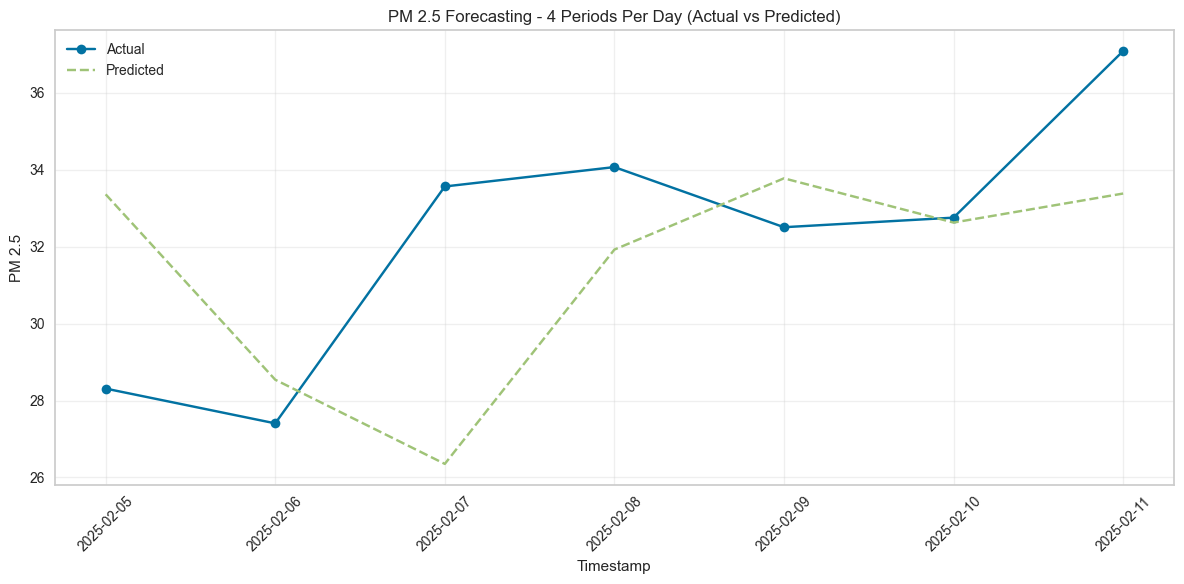

In [15]:
# *** การประเมินประสิทธิภาพของโมเดล ***

# ประเมินประสิทธิภาพของโมเดล
mae = mean_absolute_error(test["pm_2_5"], predictions) # คำนวณค่า MAE
mape = mean_absolute_percentage_error(test["pm_2_5"], predictions) * 100 # คำนวณค่า MAPE

# เนื่องจากใน sklearn ไม่มี ค่า SMAPE จึงต้อง สร้างฟังก์ชันสำหรับคำนวณค่า SMAPE
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
smape = smape(test["pm_2_5"].values, predictions.values) 

r2 = r2_score(test["pm_2_5"], predictions) # คำนวณค่า R2
accurent = 100 - mape # คำนวณค่าความแม่นยำ

# แสดงผลลัพธ์การประเมิน
print(f"MAE: {mae:.2f}") # แสดงค่า MAE
print(f"MAPE: {mape:.2f}%") # แสดงค่า MAPE
print(f"SMAPE: {smape:.2f}%") # แสดงค่า SMAPE
print(f"R2: {r2:.2f}") # แสดงค่า R2
print(f"accurent: {accurent:.2f}") # แสดงค่าความแม่นยำ

# แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6)) # กำหนดขนาดของกราฟ
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
) # แสดงกราฟ PM 2.5 Actual
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    predictions,
    label="Predicted",
    linestyle="--",
    marker="x",
) # แสดงกราฟ PM 2.5 Predicted

# แสดงกราฟ PM 2.5 Forecasting
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)") # ตั้งชื่อกราฟ
plt.xlabel("Timestamp") # ตั้งชื่อแกน X
plt.ylabel("PM 2.5") # ตั้งชื่อแกน Y
plt.legend() # แสดงคำอธิบายกราฟ
plt.grid(True, alpha=0.3) # แสดง Grid ในกราฟ

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45) # หมุน Label ของแกน X
plt.tight_layout() # ปรับ Layout ให้เข้ากับกราฟ
plt.show() # แสดงกราฟ

# ------------------------------------------------------------

In [17]:
save_model(final_arima, "Model_Predic_Pm 2.5_Final") # บันทึกโมเดลที่ปรับแต่งแล้ว

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ARIMA(order=(0,
                                                                                                                                              1,
                                                                                                                                              1),
                                                                                                                                       seasonal_order=(0,
                                                